In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] ='5'
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.50

os.environ['PYOPENGL_PLATFORM'] = 'osmesa'
import torch
import logging
import time
from argparse import ArgumentParser

import cv2
import json_tricks as json
import numpy as np


from pose_pipeline.utils.jupyter import play,play_grid
from pose_pipeline.pipeline import BlurredVideo,LiftingPerson,LiftingMethod,TopDownPerson,Video
from multi_camera.datajoint.multi_camera_dj import PersonKeypointReconstruction,SingleCameraVideo, CalibratedRecording, MultiCameraRecording,PersonKeypointReconstructionMethod
from multi_camera.datajoint.sessions import Recording
from hand_detection.hand_dj import HandPoseReconstructionMethodLookup,HandPoseReconstructionMethod, HandPoseReconstruction,HandPoseEstimationMethodLookup
from hand_detection.hand_dj import HandBbox,HandBboxMethod, HandPoseEstimation,HandPoseEstimationMethod,HandPoseEstimationVideo

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.50


[2024-02-21 15:23:19,306][INFO]: Connecting pfirouzabadi@127.0.0.1:3306
[2024-02-21 15:23:19,337][INFO]: Connected pfirouzabadi@127.0.0.1:3306


In [4]:
key = (HandPoseReconstruction & (HandBbox & 'filename like "%p71%"')).fetch('KEY')
HandPoseReconstruction & key 

recording_timestamps,camera_config_hash,cal_timestamp,reconstruction_method,estimation_method,detection_method,keypoints3d,camera_weights,reprojection_loss


In [7]:
# participant_idx = -1 #SESSION_IDX

participant_videos = (Recording & 'participant_id="71"').fetch('KEY')#[participant_idx]
vid_keys= (SingleCameraVideo & participant_videos & 'filename LIKE "%p71%_R_%"' ).fetch('KEY')
len(vid_keys)

48

In [4]:
def populate_hand_estimation(keys, detection_method = 1, estimation_method = -1, reconstruction_method = 3):
    for k in keys:
        k['detection_method'] = detection_method 

    HandBboxMethod.insert(keys,skip_duplicates=True)
    HandBbox.populate(keys)
    if estimation_method > 0:        
        for k in keys:
            k['estimation_method'] = estimation_method 
        HandPoseEstimationMethod.insert(keys,skip_duplicates=True)
        HandPoseEstimation.populate(keys)
    else:
        for i in range(5):
            for k in keys:
                k['estimation_method'] = i
            HandPoseEstimationMethod.insert(keys,skip_duplicates=True)
            HandPoseEstimation.populate(keys)
        # populate pose reconstruction as well       
            key = (CalibratedRecording * (HandPoseEstimation & keys)).fetch('KEY')
            for k in key:
                k.pop('video_project')
                k.pop('filename')
                k['reconstruction_method']=reconstruction_method
                k['estimation_method'] = i
            HandPoseReconstructionMethod.insert(key,skip_duplicates=True)
            HandPoseReconstruction.populate(key)

In [ ]:
populate_hand_estimation(key, detection_method = 1, estimation_method = -1, reconstruction_method = 3)

In [3]:
# participant_idx = 1
# participant_videos = (Recording & 'participant_id="m002"').fetch('KEY')[participant_idx]
# vid_keys= (SingleCameraVideo & participant_videos).fetch('KEY')
# len(vid_keys)

In [20]:
# participant_idx = 1
participant_id="m002"
participant_videos = (Recording & f'participant_id="51"').fetch('KEY')#[participant_idx]
reconstruction_method = 3

key = (CalibratedRecording &  participant_videos).fetch('KEY')
for k in key:
    k['reconstruction_method']= reconstruction_method
    k['estimation_method']=0
    k['detection_method']=1
key = (HandPoseReconstruction & key).fetch('KEY')


In [22]:
from multi_camera.datajoint.multi_camera_dj import Calibration

from multi_camera.analysis.optimize_reconstruction import  reprojection_loss, smoothness_loss        


#Last 21 keypoints is the hand points
# kp3d = extract_from_osim("./smooth_ik_model_marker_locations.sto")
kp3d = (HandPoseReconstruction & key).fetch1('keypoints3d')

calibration_key = (HandPoseReconstruction & Calibration & key).fetch1("KEY")
camera_calibration, camera_names = (Calibration & calibration_key).fetch1("camera_calibration", "camera_names")

keypoints = (HandPoseEstimation & key).fetch('keypoints_2d')
camera_name = (SingleCameraVideo * MultiCameraRecording * HandPoseEstimation & key).fetch('camera_name')

# Combine the right and left hand keypoints!
new_keypoints = []
for camera_k in keypoints:
    new_keypoints.append(np.asarray([np.concatenate(frame_kp,axis=0) for frame_kp in camera_k]))
keypoints = np.stack(new_keypoints)


#pad zeros for all cameras
N = max([len(k) for k in keypoints])
keypoints = np.stack(
    [np.concatenate([k, np.zeros([N - k.shape[0], *k.shape[1:]])], axis=0) for k in keypoints], axis=0
)

# work out the order that matches the calibration (should normally match)
order = [list(camera_name).index(c) for c in camera_names]
points2d = np.stack([keypoints[o][:, :, :] for o in order], axis=0)

#Get the right hand compared to Osim
reproj_loss = reprojection_loss(camera_calibration, points2d[:,:,:21,:], kp3d[:, :21, :3], huber_max=100)
from multi_camera.analysis import fit_quality
metrics, thresh, confidence = fit_quality.reprojection_quality(kp3d[:, :21, :3], camera_calibration, points2d[:,:,:21,:])
pck10 = metrics[np.argmin(np.abs(thresh - 10)), np.argmin(np.abs(confidence - 0.5))]
pck5 = metrics[np.argmin(np.abs(thresh - 5)), np.argmin(np.abs(confidence - 0.5))]

print("reprojection loss= ", reproj_loss)
print(f'precentage of points projected over 5 pixels = {pck5}')
print(f'precentage of points projected over 10 pixels = {pck10}')

reprojection loss=  312885.28
precentage of points projected over 5 pixels = 0.06078016385436058
precentage of points projected over 10 pixels = 0.08131511509418488


# Visualization

In [5]:
def render_video(video, output_file, keypoints):
    cap = cv2.VideoCapture(video)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    fps = cap.get(cv2.CAP_PROP_FPS)
    output_size = (int(w),int(h))

    fourcc = cv2.VideoWriter_fourcc(*"MP4V")
    out = cv2.VideoWriter(output_file,fourcc, fps,output_size)

    for frame_idx in tqdm(range(total_frames)):
        success, frame = cap.read()

        if not success:
            break
        keypoints = keypoints[frame_idx,:,:].copy()
        frame = draw_keypoints(frame,keypoints)
        out.write(frame)

    out.release()
    cap.release()

In [6]:
# %matplotlib inline
# def plot_all_cameras(key, frame_idx = 0,n_cols=3):
#     # using the variable axs for multiple Axes
#     from pose_pipeline.utils.visualization import draw_keypoints
#     from multi_camera.analysis.camera import project_distortion, get_intrinsic, get_extrinsic, distort_3d
#     from pose_pipeline.pipeline import Video, VideoInfo

    
#     vid_keys = (SingleCameraVideo & key).fetch('KEY')
#     num_cameras = len(vid_keys)
#     kp3d = (HandPoseReconstruction & key ).fetch1("keypoints3d")
#     # keys = (Recording & key).fetch('KEY')
#     camera_params= (Recording * Calibration & key).fetch1("camera_calibration")
#     keypoints_2d_triangulated = np.array([project_distortion(camera_params, i, kp3d) for i in range(camera_params["mtx"].shape[0])])

    
#     fig, axs = plt.subplots(num_cameras//n_cols,n_cols,figsize=(15,15))
#     for vid_idx in range(num_cameras):
#         vid_file = ( Video & vid_keys[vid_idx]).fetch('video')[0]
#         # output_file = f'{output_root}m002_camera{vid_idx}.mp4'
        
#         cap = cv2.VideoCapture(vid_file)
#         # frame_idx = 0
#         # video_writer = None
#         # pred_instances_list = []
#         keypoints_2d = (HandPoseEstimation  & key & vid_keys[vid_idx]).fetch1("keypoints_2d")
#         ###############################CHOOSE A FRAME#########################
#         # while frame_idx < 1:
#         cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
#         success, frame = cap.read()
#         # frame_idx += 1

#         if not success:
#             break
#         # radius = 10
#         # threshold = 0.2
#         # color = (255,255,255)
#         # border_color = (0,0,0)
#         for k in keypoints_2d[frame_idx]:
#             keypoints = k[:,:].copy()
#             frame = draw_keypoints(frame,keypoints)
#                         #GREEN
#             color = (30, 200, 30)
#             frame = draw_keypoints(frame, np.array(keypoints_2d_triangulated[vid_idx, frame_idx]),  threshold=0.10, border_color=color, color=color)

#         frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#         row = vid_idx // n_cols
#         col = vid_idx % n_cols
#         axs[row,col].imshow(frame)
#         os.remove(vid_file)
    


def plot_all_cameras(key, frame_idx = 0,n_cols=3):
    # using the variable axs for multiple Axes
    from pose_pipeline.utils.visualization import draw_keypoints
    
    
    vid_keys = (HandPoseEstimation * SingleCameraVideo & key).fetch('KEY')
    num_cameras = len(vid_keys)
    bbox_keys = (HandBbox & vid_keys).fetch('KEY')

    fig, axs = plt.subplots(num_cameras//n_cols,n_cols,figsize=(15,15))
    for vid_idx in range(num_cameras):
        vid_file = ( Video & vid_keys[vid_idx]).fetch('video')[0]
        # output_file = f'{output_root}m002_camera{vid_idx}.mp4'
        
        cap = cv2.VideoCapture(vid_file)
        # frame_idx = 0
        # video_writer = None
        # pred_instances_list = []
        keypoints_2d = (HandPoseEstimation & vid_keys[vid_idx]).fetch1("keypoints_2d")
        ###############################CHOOSE A FRAME#########################
        # while frame_idx < 1:
        h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        # print(h,w)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        success, frame = cap.read()
        # frame_idx += 1
        bboxes = np.asarray((HandBbox & bbox_keys[vid_idx]).fetch1("bboxes"))
        # bbox = np.min(bboxes,axis=0)-100
        # bbox[...,-2:]= np.max(bboxes,axis=0)[-2:]+100
        if not success:
            break
        # radius = 10
        # threshold = 0.2
        # color = (255,255,255)
        # border_color = (0,0,0)
        # for k in keypoints_2d:
        keypoints = keypoints_2d[frame_idx,:,:].copy()
        frame = draw_keypoints(frame,keypoints,threshold=0.1)
        for bbox in bboxes[frame_idx]:
            frame = cv2.rectangle(frame, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 255, 0), 2)  # Green color, 2 pixel thickness
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        row = vid_idx // n_cols
        col = vid_idx % n_cols
        axs[row,col].imshow(frame)
        os.remove(vid_file)
        axs[row,col].axis('off')
        axs[row,col].margins(0,0)
    plt.tight_layout()
    plt.show()
    

In [14]:
participant_idx = 1
participant_id="m002"
participant_videos = (Recording & f'participant_id="71"').fetch('KEY')#[participant_idx]
reconstruction_method = 3

key = (HandPoseEstimation &  participant_videos & 'estimation_method=-1' & 'detection_method=2').fetch('KEY')
len(key)
# for k in key:
#     k['reconstruction_method']= reconstruction_method
#     # k['estimation_method']=1
#     # k['detection_method']=1
# key = (HandPoseReconstruction & key).fetch('KEY')

48

In [ ]:
plot_all_cameras(key[:12], frame_idx = 50, n_cols=3)

# Populate and export trc


In [59]:
participant_idx = 1
participant_id="m002"
participant_videos = (Recording & f'participant_id="m002"').fetch('KEY')[participant_idx]
reconstruction_method = 3

key = (CalibratedRecording &  participant_videos).fetch('KEY')
for k in key:
    k['reconstruction_method']= reconstruction_method
    k['estimation_method']=-1
    k['detection_method']=1
(HandPoseReconstruction & key)

recording_timestamps,camera_config_hash,cal_timestamp,reconstruction_method,estimation_method,detection_method,keypoints3d,camera_weights,reprojection_loss
2023-11-15 14:46:31,6222d5655b,2023-11-15 14:49:30,3,-1,1,=BLOB=,=BLOB=,48.9559


In [ ]:
kp2ds = (HandPoseEstimation & key).fetch('keypoints_2d')
# kp2d_camera = kp2d_camera.reshape(kp2d_camera.shape[0], -1, kp2d_camera.shape[-1])    


(917, 25, 3)

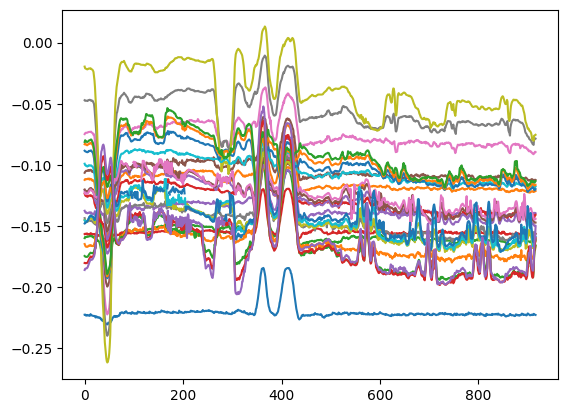

In [3]:
output_file= f'{participant_id}_{participant_idx}_reconstructed_{reconstruction_method}_w_movi.trc'
pts = HandPoseReconstruction.export_trc((HandPoseReconstruction & key ), output_file, z_offset=0, addMovi=True, smooth=False, return_points=True)
plt.plot(pts[...,0])
pts.shape

reprojection_loss [3.47692]


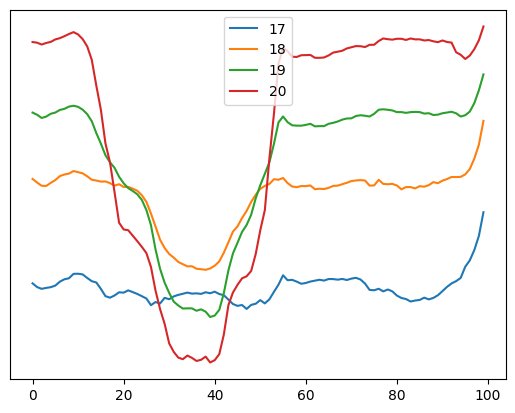

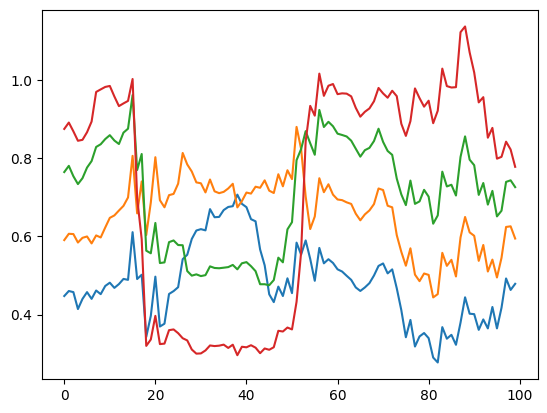

(64,)

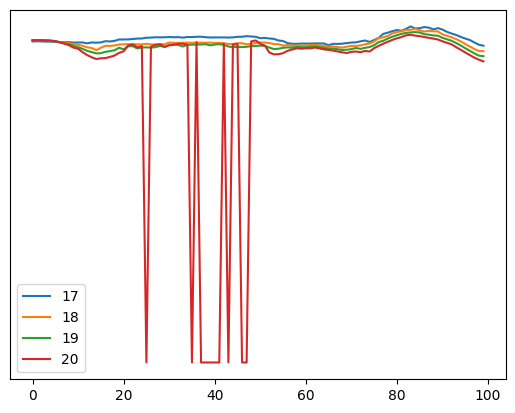

In [5]:
print('reprojection_loss',(HandPoseReconstruction & key ).fetch("reprojection_loss"))

kp3d = (HandPoseReconstruction & key ).fetch1("keypoints3d")
# np.where(kp3d==0)
kp2d = (HandPoseEstimation & SingleCameraVideo & key).fetch("keypoints_2d")[4]
kp2d = np.asarray(kp2d)
kp2d_r = kp2d[:,0,:,:]
plt.plot(kp2d_r[250:350,17:,0])
plt.yticks([])
plt.legend(range(17,21))
# plt.plot(kp2d_r[:,15:,2])
plt.pause(0.5)
plt.plot(kp2d_r[250:350,17:,2])
plt.pause(0.5)
plt.plot(kp3d[250:350,17:21,2])
plt.legend(range(17,21))
plt.yticks([])
# # np.where(kp2d==0)
# plt.pause(0.5)
# plt.plot(kp3d[250:350,17:21,3])
# plt.legend(range(17,21))
plt.yticks([])
np.unique(np.where(kp3d[...,-1]==0)[0]).shape

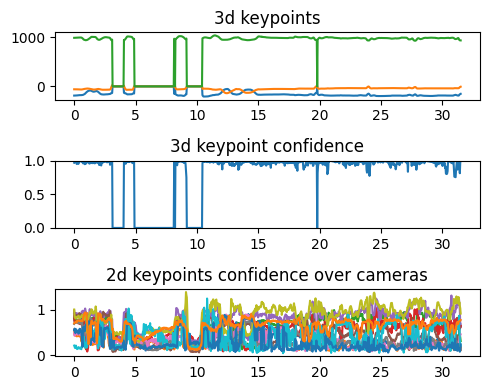

In [8]:
for j in range(20,21):
    HandPoseReconstruction.plot_joint((HandPoseReconstruction & key ),j)
    plt.pause(0.5)
    

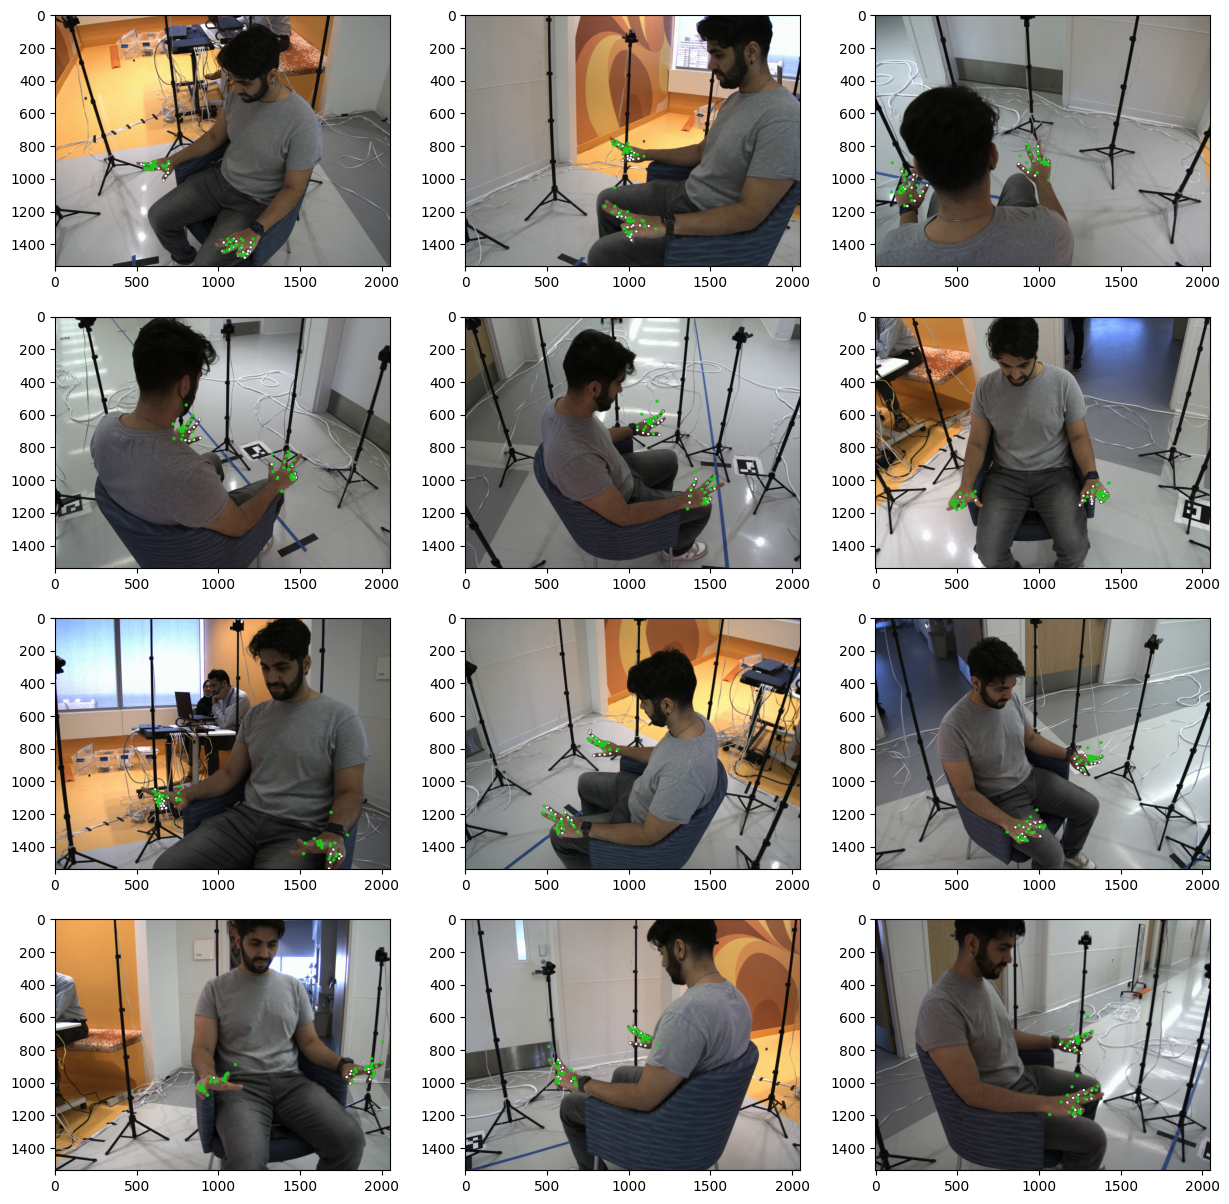

In [154]:
(HandPoseEstimationVideo & (HandPoseEstimationVideo & key).fetch('KEY')[5]).fetch('output_video')

array(['tmp61qzzlc4.mp4'], dtype=object)

In [1]:
import pandas as pd
import numpy as np
def extract_from_osim(filename):
    # Read the ".sto" file into a Pandas DataFrame
    markerDF = pd.read_csv(filename, sep='\t',skiprows=6)
    # Display the DataFrame
    markerDFkeys = markerDF.keys().values
    # extract time and markers
    markerKeys = np.array([marker.split('_')[0] for marker in markerDFkeys[1:]])[::3]
    #Extract the coordinates of all markers except time
    markersNP = markerDF.drop(columns =['time'])
    points3d = markersNP.values.reshape(markerDF.shape[0], markerKeys.shape[0], 3)
    theta = np.pi
    rotation_matrix = np.array([
        [np.cos(theta), 0, np.sin(theta)],
        [0, 1, 0],
        [-np.sin(theta), 0, np.cos(theta)]
    ])
    #rotate markers 180 along Y similar to extract trc file
    points3d = points3d@rotation_matrix
    points3d = np.take(points3d, [2, 0, 1], axis=-1)
    keypoints3dOSIM = points3d
    timeOSIM = markerDF['time'].values

    #map the markers to joint_names to be exactly same as extracted previously
    markerKeysDict ={element: index for index, element in enumerate(markerKeys)}
    # Compare elements to original indices in joint_names
    joint_names = ['Wrist','CMC1','MCP1','IP1','TIP1','MCP2','PIP2',
        'DIP2', 'TIP2', 'MCP3', 'PIP3', 'DIP3','TIP3', 'MCP4',
        'PIP4', 'DIP4', 'TIP4', 'MCP5', 'PIP5','DIP5', 'TIP5']
    if 'Dark' in filename: 
        joint_names = ['Wrist','TIP1','IP1','MCP1','CMC1','TIP2','DIP2','PIP2','MCP2',
                      'TIP3','DIP3','PIP3','MCP3','TIP4', 'DIP4',  'PIP4', 'MCP4',
                      'TIP5','DIP5', 'PIP5','MCP5']
    # joint_names =  (HandPoseEstimation&key).joint_names()
    movi_joints= [  
                "R.clavicle",#2
                "R.Shoulder.M",#39
                "R.Elbow.Lateral",#41
                # "R.Forearm",#42
                "R.Wrist.Lateral.Thumb",#43
                "R.Wrist.Medial.pinky",#44
                "R.Elbow.Medial.Inner",#57
                ]
    joint_names = movi_joints + joint_names
    markerMapping = [markerKeysDict[element] for index, element in enumerate(joint_names)]
    sorted_markerKeys = markerKeys[markerMapping]
    sorted_keypoints3dOSIM = keypoints3dOSIM[:,markerMapping,:]
    # #add the ground back to the keypoints
    # for jj in range (sorted_keypoints3dOSIM.shape[1]):
    #     sorted_keypoints3dOSIM[:,jj] = sorted_keypoints3dOSIM[:, jj] + groundRef
    #Go back to mm from m
    kp3dOsim = sorted_keypoints3dOSIM * 1000 
    return kp3dOsim

# def overlay_osim_keypoints(key, osim_file):
#     # sto_file_path = './m002_Test02_ik_marker_locations.sto'
  


In [11]:
kp3dOsim = extract_from_osim("./smooth_ik_model_marker_locations.sto")

plot_osim_triangulated_keypoints(key, kp3dOsim, -1)


In [30]:
        
import tempfile
from tqdm import tqdm
def plot_osim_triangulated_keypoints(key, none , frame_index = 0):
    from multi_camera.datajoint.multi_camera_dj import Calibration
    from multi_camera.analysis.camera import project_distortion, get_intrinsic, get_extrinsic, distort_3d

    from pose_pipeline.pipeline import Video, VideoInfo
    from pose_pipeline.utils.visualization import video_overlay, draw_keypoints
    import cv2
    from pose_pipeline.utils.bounding_box import crop_image_bbox, fix_bb_aspect_ratio

    # kp3d = (HandPoseReconstruction & key ).fetch1("keypoints3d")

    # keys = (Recording & key).fetch('KEY')
    videos = (HandPoseEstimation * MultiCameraRecording * HandPoseReconstruction * SingleCameraVideo & Recording & key).proj()
    camera_params= (Recording * Calibration & key).fetch1("camera_calibration")
    camera_names = (Recording * Calibration & key).fetch1("camera_names")
    video_keys = (videos).fetch("KEY")
    fps = np.unique((VideoInfo & video_keys[0]).fetch1("fps"))
    width = np.unique((VideoInfo & video_keys).fetch("width"))[0]
    height = np.unique((VideoInfo & video_keys).fetch("height"))[0]



    # keypoints_2d_OSIM = np.array([project_distortion(camera_params, i, ) for i in range(camera_params["mtx"].shape[0])])
    # keypoints_2d_triangulated = np.array([project_distortion(camera_params, i, kp3d) for i in range(camera_params["mtx"].shape[0])])

    num_cameras = len(camera_names)
    results = []
    if frame_index >= 0:
        n_cols = 3
        fig, axs = plt.subplots(num_cameras//n_cols,n_cols,figsize=(15,15)) 
    
    for ci in tqdm(range(num_cameras)):
        cam_idx = ci
        
        i = cam_idx
        # get camera parameters
        K = np.array(get_intrinsic(camera_params, i))

        # don't use real extrinsic since we apply distortion which does this
        R = np.eye(3)
        T = np.zeros((3,))
        cameras = {"K": [K], "R": [R], "T": [T]}


        background = np.ones((height, width, 3), dtype=np.uint8) * 127
        # BlurredVideo.populate(video_keys)
        vid_file = (Video & video_keys[i]).fetch1("video")
        vid = cv2.VideoCapture(vid_file)

        kp2d_camera = np.asarray((HandPoseEstimation & video_keys[ci]).fetch1("keypoints_2d"))
        kp2d_camera = kp2d_camera.reshape(kp2d_camera.shape[0], -1, kp2d_camera.shape[-1])    
        bboxes = np.asarray((HandBbox & video_keys[ci]).fetch1('bboxes'))
        bboxes = bboxes[:,0,:]

        bbox = np.min(bboxes,axis=0)-100
        bbox[-2:]= np.max(bboxes,axis=0)[-2:]+100
        # bbox[:2] -= bbox[:2]/2
        # bbox[-2:] += bbox[-2:]/2
        
        def render_overlay(frame, idx, frame_idx):
            #Blue
            # color = (200, 30, 30)
            # raw_frame = draw_keypoints(frame, np.array(keypoints_2d_OSIM[idx, frame_idx]), radius=10, threshold=0.10, border_color=color, color=color)

            #GREEN
            # color = (30, 200, 30)
            # raw_frame = draw_keypoints(frame, np.array(keypoints_2d_triangulated[idx, frame_idx]), radius=10, threshold=0.10, border_color=color, color=color)

            #Red
            color = (30, 200, 200)
            raw_frame = draw_keypoints(frame, np.array(kp2d_camera[frame_idx,:21]), radius=5, threshold=0.10, border_color=color, color=color)
            
            raw_frame = cv2.cvtColor(raw_frame, cv2.COLOR_BGR2RGB)

            # raw_frame = crop_image_bbox(
            #     raw_frame, bboxes[frame_idx], target_size=(288, int(288 * 1920 / 1080)), dilate=1.0
            # )[0]
            target_size= (288, int(288 * 1920 / 1080))
            dilate= 1.4 
            image = raw_frame
            # bbox = bboxes[frame_idx]            
            # bbox = fix_bb_aspect_ratio(bbox, ratio=target_size[0] / target_size[1], dilate=dilate)
            
            # three points on corner of bounding box
            src = np.asarray([[bbox[0], bbox[1]], [bbox[2] ,bbox[3]], [bbox[0], bbox[3]]])
            dst = np.array([[0, 0], [target_size[0], target_size[1]], [0, target_size[1]]])  # .astype(np.float32)
            trans = cv2.getAffineTransform(np.float32(src), np.float32(dst))
            image = cv2.warpAffine(image, trans, target_size, flags=cv2.INTER_LINEAR)

            return image
        
        def make_frames():
            list_frames = []
            # vid.set(cv2.CAP_PROP_POS_FRAMES, 0)
            for frame_num in range(0,50):
                # print(frame_num, '|', kp3d.shape[0])
                vid.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
                _, frame = vid.read()
                frame = render_overlay(frame, cam_idx, frame_num)
                list_frames.append(frame)
            return list_frames
        
        if frame_index == -1:
            results.append(make_frames())
        else:
            
            vid.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = vid.read()
            row = ci // n_cols
            col = ci % n_cols
            axs[row,col].imshow(render_overlay(frame,cam_idx,frame_index))

        os.remove(vid_file)
        vid.release()

    if frame_index == -1:
        return results

In [97]:
(BlurredVideo & video_keys).fetch('output_video')

array(['tmp1g8t2o5l.mp4'], dtype=object)

In [94]:
# participant_idx = 1
participant_videos = (Recording & f'participant_id="51"').fetch('KEY')#[participant_idx]
reconstruction_method = 3

key = (CalibratedRecording &  participant_videos).fetch('KEY')
for k in key:
    k['reconstruction_method']= reconstruction_method
    k['estimation_method']=0
    k['detection_method']=1
key = (HandPoseReconstruction & key).fetch('KEY')
(HandPoseReconstruction & key)
key = key[2]

In [95]:
videos = (HandPoseEstimation * MultiCameraRecording * HandPoseReconstruction * SingleCameraVideo & Recording & key).proj()
camera_params= (Recording * Calibration & key).fetch1("camera_calibration")
camera_names = (Recording * Calibration & key).fetch1("camera_names")
video_keys = (videos).fetch("KEY")
# BlurredVideo.populate(video_keys)

In [7]:
from multi_camera.datajoint.sessions import Subject, Session, Recording
Session & 'participant_id="m002"'

participant_id,session_date
m002,2023-11-15


In [60]:
results = plot_osim_triangulated_keypoints(key, None, -1)


  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:20<00:00,  1.73s/it]


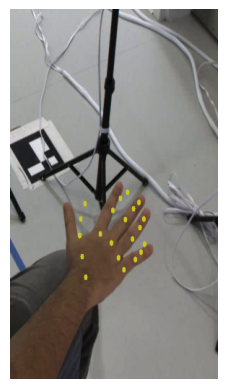

(-0.5, 287.5, 511.5, -0.5)

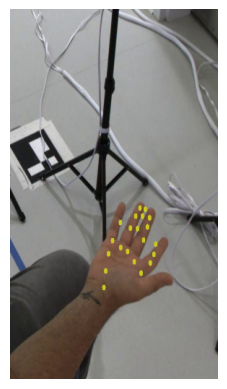

In [61]:
plt.imshow(results[3][1])
plt.axis('off')
plt.show()
plt.imshow(results[3][-5])
plt.axis('off')


In [59]:

def images_to_grid(images, n_cols=4):
    n_rows = int(np.ceil(len(images) / n_cols))
    grid = np.zeros((n_rows * images[0].shape[0], n_cols * images[0].shape[1], 3), dtype=np.uint8)
    len(images)
    for i, img in enumerate(images):
        row = i // n_cols
        col = i % n_cols
        grid[row * img.shape[0] : (row + 1) * img.shape[0], col * img.shape[1] : (col + 1) * img.shape[1], :] = img
    return grid

# collate the results into a grid
res = [images_to_grid(r) for r in zip(*results)]
# write the collated frames into a video matching the original frame rate using opencv VideoWriter
# fd, filename = tempfile.mkstemp(suffix=".mp4")
# shutil.move(filename, "collated_video.mp4")
# os.close(fd)

fourcc = cv2.VideoWriter_fourcc(*"mp4v")
writer = cv2.VideoWriter("collated_video.mp4", fourcc, 29, (res[0].shape[1], res[0].shape[0]))
for frame in tqdm(res, desc="Writing"):
    writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
writer.release()
# os.remove(filename)



Writing:   0%|          | 0/3 [00:00<?, ?it/s]

Writing: 100%|██████████| 3/3 [00:00<00:00, 87.25it/s]
